In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
%matplotlib inline

import findspark
findspark.init()

# Import and start a Spark session.
from pyspark.sql import *
import pyspark.sql.functions as F

spark = SparkSession.builder.getOrCreate()
plt.rcParams['figure.figsize'] = [12, 8]

#  JSON export of hashtag data.

This notebook contains scripts to export hashtag insights and timelines to a JSON format that can be parsed by Chart.js.

## Export of hashtag timelines.

In [2]:
# Import the #NotMyPresident dataset as a Pandas DataFrame.
nmp = spark.read.json('data/tweets-notmypresident.json').toPandas()

We first convert the `created_at` column to DateTime, to make it easier to manipulate the time data.

In [4]:
def process_tweets(df):
    """Processes a series of tweets into usable time-series data."""
    df['created_at'] = pd.to_datetime(df['created_at'] // 1000, unit='s')

In [5]:
process_tweets(nmp)

In [83]:
nmp.tail(10000)

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,retweets_count,tags,time,timezone,tweet,urls,user_id,username,video_thumb,video_url
485250,590692917800472578,2015-04-22 01:45:40,2015-04-22,,,0,[#notmypresident],590692917800472578,1,0,...,0,[],03:45:40,CET,@GovChristie talk about nepotism. You've real...,[https://twitter.com/superchargedmom/status/59...,3121653997,201_400,,
485251,590639167010385920,2015-04-21 22:15:49,2015-04-22,,,1,[#notmypresident],590640104533843968,0,1,...,0,[],00:15:49,CET,@MattRoth512 #notmypresident,[],47787970,polyh3dron,,
485252,590534889021304834,2015-04-21 18:05:55,2015-04-21,,,1,[#notmypresident],590577216930639874,0,1,...,0,[],20:05:55,CET,@Seve_Ba @Le_Ganz @BarackObama @Nessie #notmyp...,[],118148756,rock_cartright,,
485253,590482563946438656,2015-04-21 11:49:48,2015-04-21,,,0,[#notmypresident],590482563946438656,0,0,...,0,[],13:49:48,CET,Just held 2 seconds of awkward eye contact wit...,[],509201517,harry_ridgway,,
485254,590308391194497025,2015-04-21 00:17:42,2015-04-21,,,0,[#notmypresident],590308391194497025,0,0,...,0,[],02:17:42,CET,just found out Burwood councillor @JustinTaunt...,[],17484262,xavierrn,,
485255,590231202545688576,2015-04-20 19:10:59,2015-04-20,,,0,[#notmypresident],590231202545688576,1,0,...,0,[],21:10:59,CET,#NotMyPresident https://twitter.com/CJ12_/sta...,[https://twitter.com/CJ12_/status/590230043466...,139134389,buttersbc,,
485256,587646141405204480,2015-04-19 20:22:17,2015-04-19,,,0,[#notmypresident],589886757933436928,0,0,...,0,[],22:22:17,CET,@TheUniverseXP Strange I don't see one Muslim ...,[],89252447,scott_hart,,
485257,589769011547742208,2015-04-19 14:06:03,2015-04-19,,,1,"[#czech, #president, #zeman, #ashamed, #notmyp...",589792074586816513,0,1,...,0,[],16:06:03,CET,@carlbildt could pls someone tell that to #Cze...,[],154882961,vladafoltan,,
485258,589195450214965248,2015-04-17 22:49:41,2015-04-18,,,0,"[#obama, #notmypresident]",589199075838394368,0,0,...,0,[],00:49:41,CET,@t_puskaric #Obama #NotMyPresident,[],716790419,joelaust14,,
485259,588963557972271105,2015-04-17 07:13:49,2015-04-17,,,0,[#notmypresident],588963557972271105,0,0,...,1,[],09:13:49,CET,yet more displays of poor leadership #notmypre...,[],21847811,wattisup,,


We then count the number of tweets for bins of variable size (here one month).

In [112]:
def count_tweets(df, period='1M'):
    counts = pd.Series(1, index=df['created_at'])
    counts = counts.resample(period).sum()
    counts_df = counts.to_frame().reset_index()
    counts_df.columns = ['date', 'count']

    return counts_df

In [113]:
nmp_count = count_tweets(nmp, '1M')

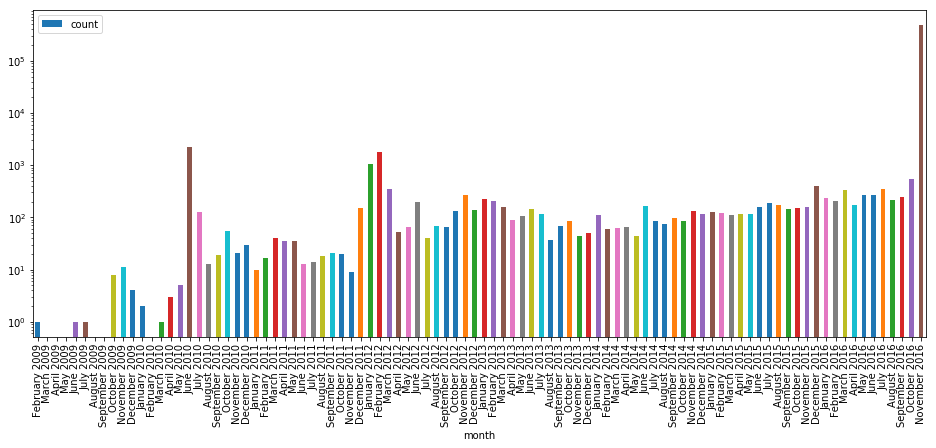

In [114]:
nmp_count['month'] = nmp_count['date'].map(lambda date: date.strftime('%B %Y'))
nmp_count.plot.bar(x='month', y='count', logy=True, figsize=(16, 6))

We finally export those results to a JSON file, which will be loaded on the JavaScript side.

In [115]:
nmp_count[['month', 'count']].to_json('exports/nmp-month.json', orient='records')

We repeat the process, this time with a zoom around Election Day.

In [6]:
nmp_zoom = nmp[(nmp.created_at > datetime.datetime(2016, 11, 8)) &\
               (nmp.created_at < datetime.datetime(2016, 11, 13))]

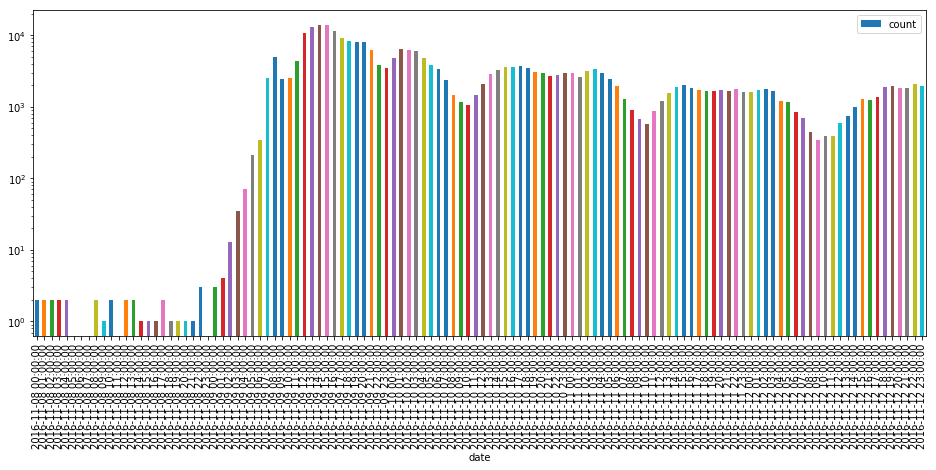

In [151]:
nmp_zoom_count = count_tweets(nmp_zoom, '1H')
nmp_zoom_count.plot.bar(x='date', y='count', logy=True, figsize=(16, 6))

In [152]:
nmp_zoom_count.to_json('exports/nmp-zoom.json', orient='records')

We peek at the first tweets of this zoom to get a feeling of the mood.

In [9]:
nmp_zoom.tail(100)

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,retweets_count,tags,time,timezone,tweet,urls,user_id,username,video_thumb,video_url
480686,796206330277167105,2016-11-09 04:22:36,2016-11-09,,,0,"[#electionnight, #nevertrump, #notmypresident]",796206330277167105,0,0,...,137,[],05:22:36,CET,"This is a national nightmare. A very dark, dar...",[],17101231,carolyn145,,
480687,796205422453620737,2016-11-09 04:19:00,2016-11-09,,,0,"[#brexit, #burnitdown, #notmypresident]",796205422453620737,0,0,...,0,[],05:19:00,CET,Goddamn. Goddamn. Goddamn. I don't understand....,[],15001909,stef_lee,,
480688,796204591645937664,2016-11-09 04:15:42,2016-11-09,,,0,[#notmypresident],796204591645937664,0,0,...,24,[],05:15:42,CET,"They want him, they can have him. #NotMyPresident",[],15533237,djrobertdrake,,
480689,796204462012530688,2016-11-09 04:15:11,2016-11-09,,,0,"[#187murderwasthecase4theusa, #nevertrump, #no...",796204462012530688,0,0,...,0,[],05:15:11,CET,He's at 187. #187murderwasthecase4theUSA #Neve...,[],2818283102,sembarmysembar,,
480690,796204436393787393,2016-11-09 04:15:05,2016-11-09,,,0,"[#yeah, #fuckthiscountry, #notmypresident]",796204436393787393,0,0,...,0,[],05:15:05,CET,"""Go out and Vote!"" They said... ""No matter who...",[],239825904,takeanotherswig,,
480691,796203521829965824,2016-11-09 04:11:27,2016-11-09,,,0,"[#electionnight, #notmypresident]",796203521829965824,0,0,...,0,[],05:11:27,CET,If Trump wins I am claiming to be Muslim so my...,[],61302941,chiruxinidp,,
480692,796203104555462656,2016-11-09 04:09:47,2016-11-09,,,0,"[#notmypresident, #electionnight]",796203104555462656,0,0,...,0,[],05:09:47,CET,This man will NEVER be the president in my eye...,[],2921564175,kipdudemeister,,
480693,796202769581572096,2016-11-09 04:08:27,2016-11-09,,,0,[#notmypresident],796202769581572096,0,0,...,0,[],05:08:27,CET,#notmypresident - looking for a new country wi...,[],18849669,trentgirl,,
480694,796202437140828162,2016-11-09 04:07:08,2016-11-09,,,0,[#notmypresident],796202437140828162,0,0,...,3,[],05:07:08,CET,I might be rocking a #notmypresident bumper st...,[],2550639571,half_deaf289,,
480695,796201761551818753,2016-11-09 04:04:27,2016-11-09,,,0,"[#notmypresident, #nevermypresident]",796201761551818753,1,0,...,8,[],05:04:27,CET,Shame on the U.S.A. for placing it's people in...,[https://twitter.com/nytgraphics/status/796195...,196328660,sauloapadilla,,
